In [1]:
%%bash
pip install lightning > /dev/null
pip install hydra-core > /dev/null

In [2]:
!git clone --recursive https://github.com/WayenVan/ctcdecode.git
!cd ctcdecode && pip install .

Cloning into 'ctcdecode'...
remote: Enumerating objects: 1400, done.
remote: Counting objects: 100% (367/367), done.
remote: Compressing objects: 100% (324/324), done.
remote: Total 1400 (delta 38), reused 358 (delta 35), pack-reused 1033 (from 1)
Receiving objects: 100% (1400/1400), 1.22 MiB | 17.58 MiB/s, done.
Resolving deltas: 100% (532/532), done.
Processing /kaggle/working/ctcdecode
  Preparing metadata (setup.py) ... done
  Created wheel for ctcdecode: filename=ctcdecode-1.0.3-cp310-cp310-linux_x86_64.whl size=19314313 sha256=9bb12568b936f25733e573ad7521e4031b97b6f54528cf518f0f8fe40c0a9efe
  Stored in directory: /tmp/pip-ephem-wheel-cache-z1b49k7_/wheels/89/bf/96/2f05f8c680d91ea5d4353d5214e76fc6de1f2620a1d9ae2cce
Successfully built ctcdecode


# Libraries

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Standard libraries
import math
import os
import random
import time
import urllib.request
from functools import partial
from urllib.error import HTTPError
from types import SimpleNamespace
import collections
from typing import Any, Dict, List, Union
import importlib
from glob import glob

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns


# Libraries for ML
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import random_split, Dataset, DataLoader, Subset
from torchvision.transforms import v2
import torchmetrics

# Torchvision
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [52]:
# PyTorch Lightning
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint, Callback
from lightning.pytorch import Trainer, seed_everything

In [6]:
from omegaconf import DictConfig, OmegaConf

In [7]:
from ctcdecode import CTCBeamDecoder

# Logging

In [8]:
import logging
import logging.config

# 5 levels: DEBUG, INFO, WARNING, ERROR, CRITICAL
log_config = {
    'version': 1,
    'disable_existing_loggers': False,
    'formatters': {
        'default': {
            'format': '%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        },
        'detailed': {
            'format': '%(asctime)s - %(name)s - %(levelname)s - %(message)s (%(filename)s:%(lineno)d)',
        },
    },
    'handlers': {
        'console': {
            'class': 'logging.StreamHandler',
            'level': 'DEBUG',
            'formatter': 'default',
            'stream': 'ext://sys.stdout',
        },
        'file': {
            'class': 'logging.FileHandler',
            'level': 'ERROR',
            'formatter': 'detailed',
            'filename': 'app.log',
            'mode': 'w',
        },
    },
    'loggers': {
#         '': {  # root logger
#             'level': 'DEBUG',
#             'handlers': ['console'],
#         },
        'my_logger': {  # the new_logger is a child of the root logger 
            'level': 'DEBUG',
            'handlers': ['console'],
            # If 'propagate' is set to True, all messages loged to new_logger 
            # are loged to its parent as well
            'propagate': False, 
        },
    },
}

def setup_logging(log_config):
#     logger = logging.getLogger('test_logger')
#     if logger.hasHandlers():
#         logger.handlers.clear()
    logging.config.dictConfig(log_config)

In [9]:
setup_logging(log_config)

# New logger defined in the new configuration
my_logger = logging.getLogger('my_logger')
my_logger.debug('This is a debug message from the my_logger.')
my_logger.info('This is an info message from the my_logger.')
my_logger.warning('This is a warning message from the my_logger.')
my_logger.error('This is an error message from the my_logger.')
my_logger.critical('This is a critical message from the my_logger.')

2025-03-06 09:48:12,464 - my_logger - DEBUG - This is a debug message from the my_logger.
2025-03-06 09:48:12,464 - my_logger - INFO - This is an info message from the my_logger.
2025-03-06 09:48:12,465 - my_logger - WARNING - This is a warning message from the my_logger.
2025-03-06 09:48:12,466 - my_logger - ERROR - This is an error message from the my_logger.
2025-03-06 09:48:12,467 - my_logger - CRITICAL - This is a critical message from the my_logger.


# Wandb

In [10]:
from kaggle_secrets import UserSecretsClient
secret_label = "wandb"
secret_value = UserSecretsClient().get_secret(secret_label)

import wandb
wandb.login(key=secrect_value)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: thdquan (thdquan-no). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Configuration

In [11]:
config = {
    'general': {
        'workspace': 'kaggle',
        'project_name': 'VNHandWritten_OCR',
        'input_dir' : "/kaggle/input/vn-handwritten-images/vn_handwritten_images",
        'output_dir' : "/kaggle/working",
        # 'input_dir' : "./vn_handwritten_images",
        # 'output_dir' : ".",
        'images_dir' : '${general.input_dir}' + '/data',
        'chkpt_fname': None,
        'seed': 13,
        'experiment': 'exper_9',
        'logger_name': '${general.experiment}' + '_name',
        'logger_version': '${general.experiment}' + '_version',
        'wandb_artifact_name': '${general.experiment}' + '_artifact_name',
    },
}

config['training'] = {
    # 'lr': 1e-4,
    # 'batch_size': 4,
    'lr': 1e-4,
    'batch_size': 8,
    'epochs': 3,
    'optimizers': [
        {
            'class_name': 'torch.optim.AdamW',
            'params': {'lr': '${training.lr}'}
        },  
    ],
    'schedulers': [
        {
            'class_name': 'torch.optim.lr_scheduler.ReduceLROnPlateau',
            'params': {
                'mode': 'min', 'factor': 0.2,
                'patience': 10, 'threshold': 1e-4, 
                'verbose': True,
            },
        }
    ],
    'loss': {
        'class_name': 'torch.nn.CTCLoss',
        'params': {
            'blank': 0,
        }
    },
}

In [12]:
config['dataset'] = {
    # 'augmentation': {
    #     'train': {
    #         'class_name': 'albumentations.Compose',
    #         'params': {
    #             'transforms': [
    #                 {
    #                    'class_name': 'albumentations.Resize', 
    #                     'params': {
    #                        'height': '${dataset.image_h}',
    #                        'width': '${dataset.image_w}', 
    #                         'p': 1.0
    #                     }
    #                },
    #                 {
    #                     'class_name': 'albumentations.ToGray',
    #                     'params': {
    #                         'p': 1.0
    #                     }
    #                 }
                    
    #             ]
    #         }
    #     },
    #     #################
    #     'valid': {
    #         'class_name': 'albumentations.Compose',
    #         'params': {
    #             'transforms': [
    #                 {
    #                    'class_name': 'albumentations.Resize', 
    #                     'params': {
    #                        'height': '${dataset.image_h}',
    #                        'width': '${dataset.image_w}', 
    #                         'p': 1.0
    #                     }
    #                },
                    
    #             ]
    #         }
    #     }
    # },
    # 'preprocessing': {
    #     'class_name': 'albumentations.Compose',
    #     'params': {
    #        'transforms': [
    #            {
    #                'class_name': 'albumentations.pytorch.transforms.ToTensorV2', 
    #                'params': {'p': 1.0}
    #            }
    #        ]
    #     },
    # },
    'image_h': 103,
    'image_w': 1853,
    'vocab_size': 140+1,
    'vocabs': (
        "_ #'()+,-./0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYabcde"
        "ghiklmnopqrstuvwxyzÂÊÔàáâãèéêìíòóôõùúýăĐđĩũƠơưạ"
        "ảấầẩậắằẵặẻẽếềểễệỉịọỏốồổỗộớờởỡợụủỨứừửữựỳỵỷỹ"
    ),
    'test_size': 0.2,
    'num_workers': 4,
    "persistent_workers": True,
    # 'num_workers': 0,
    # "persistent_workers": False,
}

In [13]:
cfg = OmegaConf.create(config)
my_logger.info(f"Project's configuration:\n{OmegaConf.to_yaml(cfg)}")

2025-03-06 09:48:21,494 - my_logger - INFO - Project's configuration:
general:
  workspace: kaggle
  project_name: VNHandWritten_OCR
  input_dir: /kaggle/input/vn-handwritten-images/vn_handwritten_images
  output_dir: /kaggle/working
  images_dir: ${general.input_dir}/data
  chkpt_fname: null
  seed: 13
  experiment: exper_9
  logger_name: ${general.experiment}_name
  logger_version: ${general.experiment}_version
  wandb_artifact_name: ${general.experiment}_artifact_name
training:
  lr: 0.0001
  batch_size: 8
  epochs: 3
  optimizers:
  - class_name: torch.optim.AdamW
    params:
      lr: ${training.lr}
  schedulers:
  - class_name: torch.optim.lr_scheduler.ReduceLROnPlateau
    params:
      mode: min
      factor: 0.2
      patience: 10
      threshold: 0.0001
      verbose: true
  loss:
    class_name: torch.nn.CTCLoss
    params:
      blank: 0
dataset:
  image_h: 103
  image_w: 1853
  vocab_size: 141
  vocabs: '_ #''()+,-./0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYabcdeghiklmnopqrstuvw

# Utils

In [14]:
def load_obj(obj_path: str, default_obj_path: str = "__main__") -> Any:
    """Extract an object from a given path.
        Args:
            obj_path: Path to an object to be extracted, including the object name.
            default_obj_path: Default object path.
        Returns:
            Extracted object.
        Raises:
            AttributeError: When the object does not have the given named attribute.
    """
    obj_path_list = obj_path.rsplit(".", 1)
    obj_path = obj_path_list.pop(0) if len(obj_path_list) > 1 else default_obj_path
    obj_name = obj_path_list[0]
    module_obj = importlib.import_module(obj_path)
    if not hasattr(module_obj, obj_name):
        raise AttributeError(
            f"Object `{obj_name}` cannot be loaded from `{obj_path}`."
        )
    return getattr(module_obj, obj_name)

def load_value(value_cfg: Union[Dict, List, Any]):
    if type(value_cfg) == dict:
        keys = list(value_cfg.keys())
        if keys == ['class_name', 'params']:
            return load_obj(value_cfg['class_name'])(**load_value(value_cfg['params']))
        else:
            return {k: load_value(v) for k, v in value_cfg.items()}
    elif type(value_cfg) == list:
        a= [load_value(v) for v in value_cfg]
        return a
    else:
        return value_cfg 

def seed_worker(worker_id):
    np.random.seed(worker_id)
    random.seed(worker_id)

In [211]:
def get_max_value(dtype):
    if np.issubdtype(dtype, np.integer):
        return float(np.iinfo(dtype).max)
    elif np.issubdtype(dtype, np.floating):
        return np.finfo(dtype).max
    else:
        raise TypeError("Unsupported data type")
        
def read_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    max_v = get_max_value(img.dtype)
    img = img.astype('float32') # original is uint16
    if max_v:
        img /= max_v # scale image to [0, 1]
    return img

def plot_images(images, labels, title, ncols=2):
    num_images = len(images)
    fig, axes = plt.subplots(math.ceil((len(images))/ncols),
                             ncols, figsize=(10, num_images)) # (w, h)
    # Adjust spacing
    plt.subplots_adjust(wspace=1, hspace=1)  # Controls blank space between plots
    fig.suptitle(title)
    # Loop through images and axes
    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img)  # Show image
        ax.set_title(label)  # Add label
        ax.axis("off")  # Remove axis
    
    plt.show()
    

In [16]:
def resize_with_padding(image, target_size=(224, 224)): #(h, w)
    h, w = image.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)  # Giữ nguyên tỷ lệ
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Padding để ảnh đạt kích thước chuẩn
    pad_h = (target_size[0] - new_h) // 2
    pad_w = (target_size[1] - new_w) // 2
    
    #https://docs.opencv.org/4.x/d3/df2/tutorial_py_basic_ops.html
    padded = cv2.copyMakeBorder(resized, pad_h, target_size[0] - new_h - pad_h,
                                pad_w, target_size[1] - new_w - pad_w,
                                cv2.BORDER_REPLICATE)
    return padded

class ResizeWithPadding(ImageOnlyTransform):
    def __init__(self, h=224, w=224, p=0.5):
        super().__init__(p)
        self.h = h
        self.w = w
        self.p = p

    def apply(self, img, copy=True, **params):
        if np.random.uniform(0, 1) > self.p:
            return img
        if copy:
            img = img.copy()
        return resize_with_padding(img, (self.h, self.w))

# EDA

In [17]:
import json

with open(os.path.join(cfg.general.input_dir, "labels.json"), "r", encoding="utf-8") as file:
    summ = json.load(file)
tupled_summ = [(k,v)for k,v in summ.items()]

In [18]:
summ_df = pd.DataFrame(tupled_summ, columns=['file_name', 'address'])
summ_df.head(5)

,file_name,address
0,1.jpg,"Số 3 Nguyễn Ngọc Vũ, Hà Nội"
1,2.jpg,"Số 30 Nguyên Hồng, Láng Hạ, Đống Đa, Hà Nội"
2,3.jpg,"58 Thái Thịnh, Đống Đa, Hà Nội"
3,4.jpeg,"Số 370/8 khu phố 5B, phường Tân Biên, Biên Hòa..."
4,5.jpg,"Vĩnh Trung Plaza, B, 255-257 đường Hùng Vương,..."


In [19]:
summ_df['file_path'] = cfg.general.images_dir + '/' + summ_df['file_name']

In [25]:
#def encode_label(label):
joined_addresses = summ_df['address'].sum()
characters_set = sorted(set(joined_addresses))
characters = ''.join(characters_set)
print(f"{len(characters)} characters:\n{characters}")

140 characters:
 #'()+,-./0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYabcdeghiklmnopqrstuvwxyzÂÊÔàáâãèéêìíòóôõùúýăĐđĩũƠơưạảấầẩậắằẵặẻẽếềểễệỉịọỏốồổỗộớờởỡợụủỨứừửữựỳỵỷỹ


In [26]:
vocabs = '_' + characters
(vocabs)

"_ #'()+,-./0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYabcdeghiklmnopqrstuvwxyzÂÊÔàáâãèéêìíòóôõùúýăĐđĩũƠơưạảấầẩậắằẵặẻẽếềểễệỉịọỏốồổỗộớờởỡợụủỨứừửữựỳỵỷỹ"

In [27]:
char2idx = {}
idx2char = {}
for i, c in enumerate(vocabs):
    char2idx[c] = i 
    idx2char[i] = c

In [28]:
def encode_address(address):
    return [char2idx[c] for c in address]
summ_df['target'] = summ_df['address'].apply(encode_address)

In [29]:
summ_df['target_length'] = (summ_df['target']).apply(
    lambda x: len(x) 
)

In [30]:
summ_df.head(5)

,file_name,address,file_path,target,target_length
0,1.jpg,"Số 3 Nguyễn Ngọc Vũ, Hà Nội",/kaggle/input/vn-handwritten-images/vn_handwri...,"[40, 119, 1, 14, 1, 35, 52, 65, 69, 113, 58, 1...",27
1,2.jpg,"Số 30 Nguyên Hồng, Láng Hạ, Đống Đa, Hà Nội",/kaggle/input/vn-handwritten-images/vn_handwri...,"[40, 119, 1, 14, 11, 1, 35, 52, 65, 69, 80, 58...",43
2,3.jpg,"58 Thái Thịnh, Đống Đa, Hà Nội",/kaggle/input/vn-handwritten-images/vn_handwri...,"[16, 19, 1, 41, 53, 75, 54, 1, 41, 53, 116, 58...",30
3,4.jpeg,"Số 370/8 khu phố 5B, phường Tân Biên, Biên Hòa...",/kaggle/input/vn-handwritten-images/vn_handwri...,"[40, 119, 1, 14, 18, 11, 10, 19, 1, 55, 53, 65...",56
4,5.jpg,"Vĩnh Trung Plaza, B, 255-257 đường Hùng Vương,...",/kaggle/input/vn-handwritten-images/vn_handwri...,"[43, 93, 58, 53, 1, 41, 62, 65, 58, 52, 1, 37,...",64


In [31]:
def get_hw(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, c = img.shape
    return h, w
img_hws = [get_hw(fpath) for fpath in summ_df['file_path']]

In [32]:
heights, widths = list(zip(*img_hws))
summ_df['h'], summ_df['w'] = heights, widths

In [33]:
numeric_statistics_df = summ_df.describe(include=[np.number])
unique_numeric_statistics = summ_df[['target_length', 'h', 'w']].nunique()
numeric_statistics_df.loc['unique'] = unique_numeric_statistics
numeric_statistics_df

,target_length,h,w
count,1838.000000,1838.000000,1838.000000
mean,56.406420,103.784548,1851.989119
std,8.735869,14.407150,54.892352
min,24.000000,94.000000,955.000000
25%,51.000000,102.000000,1853.000000
50%,58.000000,103.000000,1853.000000
75%,63.000000,103.000000,1854.000000
max,69.000000,376.000000,2694.000000
unique,45.000000,33.000000,62.000000


In [34]:
summ_df['bin10_target_length'] = (summ_df['target_length']-1)//10+1

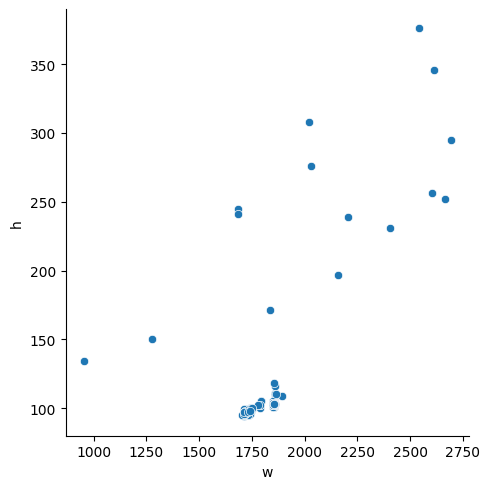

In [35]:
sns.relplot(data=summ_df, x="w", y="h", kind='scatter' )

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


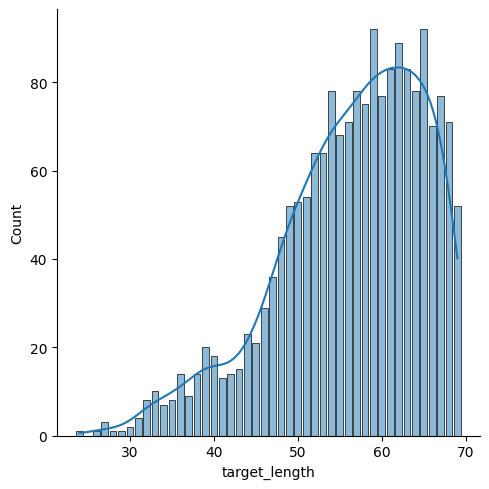

In [36]:
sns.displot(data=summ_df, x='target_length',
            discrete=True, shrink=0.8, kde=True)

In [37]:
random_samples = summ_df.sample(10)
images = random_samples['file_path'].apply(read_image).to_list()
addresses = random_samples['address'].to_list()

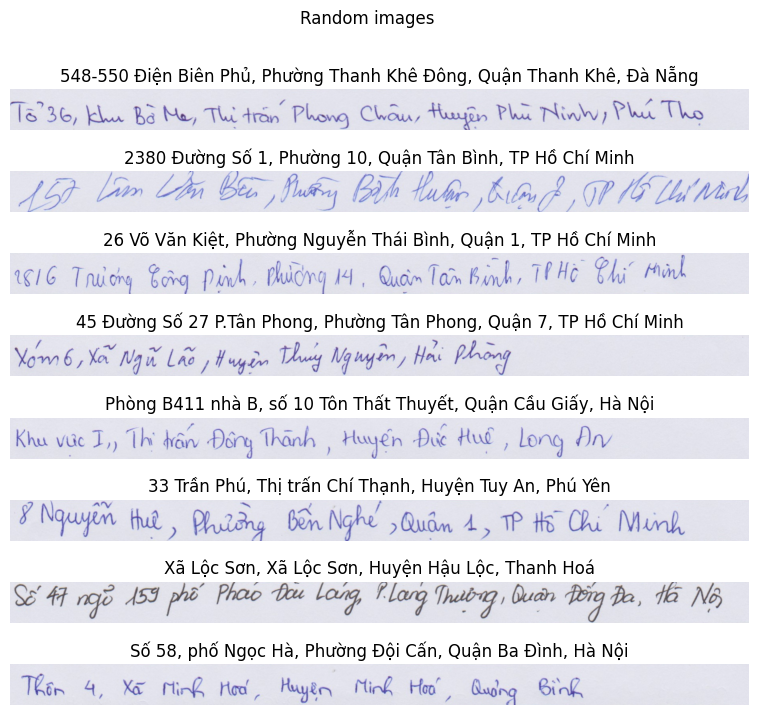

In [212]:
plot_images(images, addresses, 'Random images', ncols=1)

In [39]:
transform_lst = [
    A.Resize(128, 2048, p=1),
    ResizeWithPadding(128, 2048, p=1),
    A.Rotate(limit=2, p=1),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.02, 0.02), shear=(-2, 2), p=1),
    A.GaussNoise(var_limit=(0.03, 0.05), p=1),
    A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=1),
    A.ImageCompression(quality_range=(80, 90), p=1),
    A.MotionBlur(blur_limit=3, p=1),
    A.ToGray(p=1),  # Nếu muốn chuyển ảnh sang grayscale đôi khi
]

transform_names = [
    'Origin', 'Resize', 'Resize with padding', 'Rotate', 'Affine', 'Gauss Noise',
    'Random Brightness Contrast', 'Image Compression', 'Motion Blur', 'To Gray'
]

In [40]:
highest_img = read_image(summ_df.loc[summ_df['h'].idxmax(), 'file_path'])
widest_img = read_image(summ_df.loc[summ_df['w'].idxmax(), 'file_path'])
transformed_highest_img = [transform(image=highest_img)['image'] for transform in transform_lst]
transformed_widest_img = [transform(image=widest_img)['image'] for transform in transform_lst]


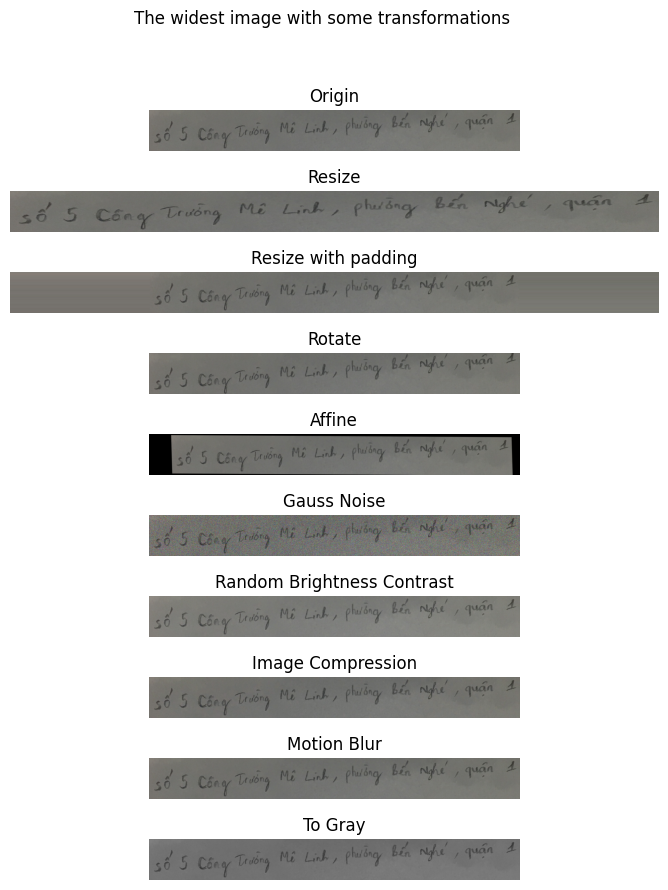

In [213]:
plot_images([widest_img] + transformed_widest_img, transform_names,
    'The widest image with some transformations', 1
)

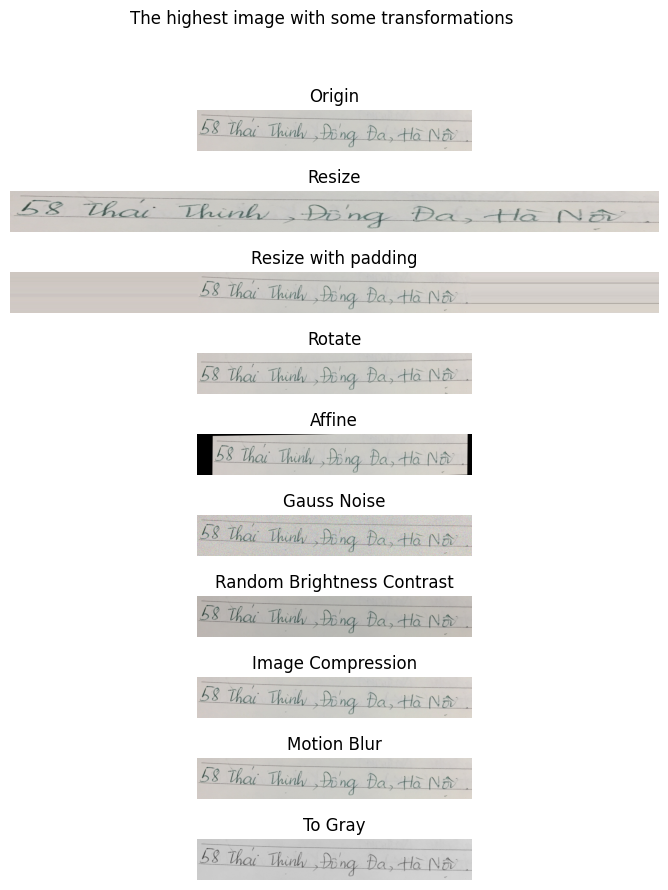

In [214]:
plot_images(
    [highest_img] + transformed_highest_img, transform_names,
    'The highest image with some transformations', 1
)

# Augmentation

In [43]:
def get_transform(augmentation_cfg):
    augmentation_cfg = OmegaConf.to_container(augmentation_cfg, resolve=True)
    transform = load_obj(augmentation_cfg['class_name'])(**load_value(augmentation_cfg['params']))
    return transform

# Dataset

In [84]:
class VNHandwrittenDataset(Dataset):
    def __init__(self, df, augmentation=None,
        preprocessing=None
    ):
        self.df = df
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __len__(self):
        return self.df.shape[0]
    
    def get_raw_item(self, idx):
        image = read_image(self.df.loc[idx, "file_path"])
        return image
    
    def __getitem__(self, idx):
        image = self.get_raw_item(idx)
        if self.augmentation:
            augmented = self.augmentation(image=image)
            image = augmented['image']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=image)
            image = preprocessed['image']

        target = torch.tensor(self.df.loc[idx, 'target'])
        text = self.df.loc[idx, 'address']
        return image, target, text
        

In [79]:
def collate_fn(batch):
    inputs, targets, texts = zip(*batch)
    inputs = torch.stack(inputs, dim=0)
    targets = list(targets)
    texts = list(texts)
    return inputs, targets, texts

class LitVNHandwrittenDataset(L.LightningDataModule):
    def __init__(
        self, cfg, df, **kwargs
    ):
        super().__init__()
        self.train_augmentation = A.Compose([
            A.Resize(cfg.dataset.image_h, cfg.dataset.image_w, p=1),
            
            A.OneOf([
                A.Rotate(limit=2, p=0.5),
                A.Affine(
                    scale=(0.95, 1.1), translate_percent=(0.02, 0.02), shear=(-2, 2),
                    p=0.5
                ),
            ], p=0.5),

            A.OneOf([
                A.GaussNoise(var_limit=(0.03**2, 0.05**2), p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=0.5),
                A.ImageCompression(quality_range=(90, 100), p=0.5),
            ], p=0.5),

            # A.OneOf([
            #     A.MotionBlur(blur_limit=3, p=0.5),
            # ], p=0.5),
        ])

        self.val_augmentation = A.Compose([
            A.Resize(cfg.dataset.image_h, cfg.dataset.image_w, p=1),
        ])
        
        self.preprocessing = A.Compose([
            A.pytorch.transforms.ToTensorV2(p=1)
        ])
        self.save_hyperparameters()

    def prepare_data(self):
        pass
        
    def setup(self, stage: str):
        if stage == "fit":
            train_df, valid_df = train_test_split(
                self.hparams.df, test_size=self.hparams.cfg.dataset.test_size,
                stratify=self.hparams.df['bin10_target_length']
            )
            train_df.reset_index(drop=True, inplace=True)
            valid_df.reset_index(drop=True, inplace=True)
            self.train_ds = VNHandwrittenDataset(
                train_df,
                augmentation=self.train_augmentation,
                preprocessing=self.preprocessing
            )
            self.val_ds = VNHandwrittenDataset(
                valid_df,
                augmentation=self.val_augmentation,
                preprocessing=self.preprocessing
            )
            
    def train_dataloader(self):
        return DataLoader(
            self.train_ds, 
            batch_size=self.hparams.cfg.training.batch_size,
            shuffle=True, drop_last=False,
            pin_memory=True,
            generator=torch.Generator().manual_seed(self.hparams.cfg.general.seed),\
            collate_fn=collate_fn,
            num_workers=self.hparams.cfg.dataset.num_workers,
            persistent_workers=self.hparams.cfg.dataset.persistent_workers,
            worker_init_fn=seed_worker,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds, 
            batch_size=self.hparams.cfg.training.batch_size,
            shuffle=False, drop_last=False,
            num_workers=self.hparams.cfg.dataset.num_workers,
            pin_memory=True,
            worker_init_fn=seed_worker,
            generator=torch.Generator().manual_seed(self.hparams.cfg.general.seed),
            persistent_workers=self.hparams.cfg.dataset.persistent_workers,
            collate_fn=collate_fn
        )

# Model


In [46]:
class CRNN(nn.Module):

    def __init__(self, vocab_size, dropout=0.5):
        super(CRNN, self).__init__()

        self.dropout = nn.Dropout(dropout)

        self.convlayer = nn.Sequential(
            nn.Conv2d(3, 64, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2), 2),

            nn.Conv2d(64, 128, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,2), 2),

            nn.Conv2d(128, 256, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2,2), 2), 
            self.dropout
        )

        self.mapSeq = nn.Sequential(
            nn.Linear(3072, 256),
            self.dropout
        )
        
        self.lstm_0 = nn.GRU(256, 256, bidirectional=True)  
        self.lstm_1 = nn.GRU(512, 256, bidirectional=True)

        self.out = nn.Sequential(
            nn.Linear(512, vocab_size),
        )
        
        
    def forward(self, x): 
        # my_logger.debug("Model flow's debug")
        x = self.convlayer(x)
        # my_logger.debug(x.shape)

        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)
        # my_logger.debug(x.shape)
     
        x = self.mapSeq(x)
        # my_logger.debug(x.shape)
        x, _ = self.lstm_0(x)
        # my_logger.debug(x.shape)
        x, _ = self.lstm_1(x)
        # my_logger.debug(x.shape)
        x = self.out(x)
        # my_logger.debug(x.shape)
        return x.permute(1, 0, 2)

In [47]:
def create_example_input(cfg):
    input_sample = torch.zeros((
        3, cfg.dataset.image_h, cfg.dataset.image_w),
        dtype=torch.float32
    ).unsqueeze(0)
    return input_sample


In [197]:
class LitVNHandwrittenModel(L.LightningModule):
    def __init__(
        self, cfg, **kwargs
    ):
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        
        self.model = CRNN(cfg.dataset.vocab_size)
        self.input_sample = create_example_input(cfg)
        self.criterion = load_obj(cfg.training.loss.class_name)(
            **OmegaConf.to_container(
                cfg.training.loss.params, resolve=True)
        )
        # https://github.com/parlance/ctcdecode
        self.decoder = CTCBeamDecoder(
            labels=cfg.dataset.vocabs,
            model_path=None,
            alpha=0,
            beta=0,
            cutoff_top_n=40,
            cutoff_prob=1.0,
            beam_width=10,
            num_processes=cfg.dataset.num_workers,
            blank_id=0,
            log_probs_input=True
        )
        self.__configure_metrics__()
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, targets, texts = batch
        logits = self.model(inputs)
        loss = self.__calc_loss__(logits, targets)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        inputs, targets, texts = batch
        logits = self.model(inputs)
        loss = self.__calc_loss__(logits, targets)
        self.log(
            "val_loss", loss, 
            on_epoch=True, prog_bar=True, logger=True
        )

        pred_texts = self.__decode__(
            logits.detach().cpu()
        )
        self.val_metrics.update(pred_texts, texts)
        # for i in range(len(texts)):
        #     print("#######################")
        #     print(f"prediction text: {pred_texts[i]}")
        #     print(f"ground truth text: {texts[i]}")
        # print(metric_values)
        # sys.exit()
        self.log_dict(
            self.val_metrics, on_step=True, 
            on_epoch=True, prog_bar=True, logger=True
        )
        return {'loss': loss}

    def predict_step(self, batch, batch_idx):
        inputs, targets, texts = batch
        logits = self.model(inputs)

        pred_texts = self.__decode__(
            logits.detach().cpu()
        )
        return {
            "images": inputs, 
            "prediction_texts": pred_texts, 
            "ground_truth_texts": texts
        }
            
    def __configure_metrics__(self):
        metrics = torchmetrics.MetricCollection([
            torchmetrics.text.CharErrorRate(),
            torchmetrics.text.WordErrorRate(),
        ])
        self.val_metrics = metrics.clone(prefix='val_')
        self.test_metrics = metrics.clone(prefix='test_')

    def configure_optimizers(self):
        optimizer = load_obj(self.hparams.cfg.training.optimizers[0].class_name)(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            **OmegaConf.to_container(
                self.hparams.cfg.training.optimizers[0].params, resolve=True
            )
        )
        lr_scheduler_cfg = {
            'scheduler': load_obj(self.hparams.cfg.training.schedulers[0].class_name)(
                optimizer,
                **OmegaConf.to_container(
                    self.hparams.cfg.training.schedulers[0].params, resolve=True
                )
            ),
            'interval': 'epoch',
            "frequency": 1,
            "monitor": "val_loss",
            "strict": True,
            "name": None,
        }    
        optimizers, lr_scheduler_cfgs = [optimizer], [lr_scheduler_cfg]
        
        return optimizers, lr_scheduler_cfgs

    def __encode__(self, targets):
        joined_targets = torch.cat(targets, dim=0)
        target_lengths = torch.tensor([target.size(0) for target in targets])
        return joined_targets, target_lengths

    def __calc_loss__(self, logits, targets):
        targets, target_lengths = self.__encode__(targets)
        logit_lengths = logits_lens = torch.full(
            size=(logits.size(1),), 
            fill_value=logits.size(0), 
            dtype=torch.int32
        )
    
        loss = self.criterion(
            logits.log_softmax(2),
            targets,
            logit_lengths,
            target_lengths)
        return loss
        
    def __decode__(self, logits):
        def postprocess(beam_result):
            text_lst = []
            pre_c = '$'
            for c in beam_result:
                if c != '_' and c != pre_c:
                    text_lst.append(c)
                pre_c = c
                
            return ''.join(text_lst)
            
        pred_texts = []
        beam_results, beam_scores, \
        timesteps, out_lens = self.decoder.decode(
            logits.log_softmax(2).permute(1, 0, 2)
        )
        for i in range(beam_results.shape[0]):
            max_idx = beam_scores[i].argmax()
            pred_text = "".join([
                self.decoder._labels[c] for c in beam_results[i][max_idx][:out_lens[i][max_idx]]
            ])
            # print(pred_text)
            pred_text = postprocess(pred_text)
            # print(pred_text)
            pred_texts.append(pred_text)
        return pred_texts

# Callbacks

In [94]:
class LitCheckpointTransferer(Callback):
    def __init__(self, artifact_name, artifact_alias):
        super().__init__()
        self.artifact_name = artifact_name
        self.artifact_alias = artifact_alias

    def on_fit_end(self, trainer, pl_module):
        # Check for existing artifacts with the same name and delete them if necessary
        run = wandb.run
        try:
            api = wandb.Api()
            existing_artifacts = api.artifacts(
                type_name='directory',
                name=f"{run.entity}/{run.project}/{self.artifact_name}"
            )

            for artifact in existing_artifacts:
                if artifact.type == "directory":
                    artifact.delete(delete_aliases=True)
            my_logger.info(f'Delete the existing artifacts')
        except Exception as e:
            my_logger.info(f'Error deleting checkpoint artifacts: {e}')

        # Create a new artifact
        ckpt_dirpath = trainer.checkpoint_callback.dirpath
        save_dir = trainer.loggers[0].save_dir
        ckpt_rel_dirpath = os.path.relpath(ckpt_dirpath, save_dir)
        artifact = wandb.Artifact(name=self.artifact_name, type="directory")
        artifact.add_dir(ckpt_dirpath, name=ckpt_rel_dirpath)
        # Add files from the directory to the artifact
        # for root, dirs, files in os.walk(directory_to_save):
        #     for file in files:
        #         file_path = os.path.join(root, file)
        #         # Add file to the artifact
        #         artifact.add_file(file_path, name=file_path)
        #         print(file_path)
        #         print(os.path.relpath(file_path, directory_to_save))

        # Log the artifact
        try:
            wandb.log_artifact(artifact, aliases=self.artifact_alias)
            my_logger.info(f"Files uploaded from {ckpt_rel_dirpath}")
        except Exception as e:
            my_logger.info(f"Error uploading files: {e}")
            
def download_wandb_checkpoint_artifacts(
    wandb_logger, artifact_name, artifact_alias, **kwargs
):
    
    try:
        save_dir = wandb_logger.save_dir
        run = wandb_logger.experiment
        # artifact = api.artifact(f"{entity}/{project}/{artifact_name}:{alias}")
        artifact = run.use_artifact(f"{artifact_name}:{artifact_alias}", type='directory')
        artifact_dir = artifact.download(save_dir)
        my_logger.info(f"Checkpoint downloaded to {artifact_dir}")
    except Exception as e:
        my_logger.info(f"Error downloading files: {e}")

# Trainning

In [53]:
seed_everything(cfg.general.seed, workers=True)

INFO: Seed set to 13


13

In [80]:
dataset = LitVNHandwrittenDataset(
    cfg, summ_df)

dataset.setup('fit')
train_dl = dataset.train_dataloader()
val_dl = dataset.val_dataloader()

In [198]:
# import os

# if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:  # Kiểm tra nếu đang chạy trên Kaggle
#     DATA_DIR = "/kaggle/input/your-dataset-folder"
#     OUTPUT_DIR = "/kaggle/working"
# else:  # Đang chạy trên local
#     DATA_DIR = "/path/to/local/dataset"
#     OUTPUT_DIR = "/path/to/local/output"

# print("Data directory:", DATA_DIR)
# print("Output directory:", OUTPUT_DIR)

lit_model = LitVNHandwrittenModel(cfg)
if cfg.general.chkpt_fname:
    chkpt_fpath = os.path.join(cfg.general.ouput_dir, cfg.general.chkpt_fname)
    lit_model = LitVNHandwrittenModel.load_from_checkpoint(chkpt_fpath)


In [184]:
loggers = [
    L.pytorch.loggers.WandbLogger(
        save_dir=cfg.general.output_dir,
        project=cfg.general.project_name,
        name=cfg.general.logger_name,
        version=cfg.general.logger_version,
        entity='thdquan-no',
        log_model=False,
    )
]

callbacks = [
    L.pytorch.callbacks.ModelCheckpoint(
        mode='min',
        monitor='val_loss',
        verbose=True, 
        save_last=True,
        save_top_k=2
    ),
    L.pytorch.callbacks.EarlyStopping(
        "val_loss", min_delta=1e-7,
        patience=20, verbose=True,
        mode='min'
    ),
    L.pytorch.callbacks.LearningRateMonitor(logging_interval='epoch'),
    LitCheckpointTransferer(
        artifact_name=cfg.general.wandb_artifact_name,
        artifact_alias='latest',
    )
]

In [98]:
download_wandb_checkpoint_artifacts(
    wandb_logger=loggers[0], 
    artifact_name=cfg.general.wandb_artifact_name,
    artifact_alias='latest',
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
wandb: Downloading large artifact exper_9_artifact_name:latest, 136.80MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.4


2025-03-06 11:02:08,914 - my_logger - INFO - Checkpoint downloaded to /kaggle/working


In [103]:
cfg.training.epochs = 150
trainer = L.Trainer(
    logger=loggers,
    callbacks=callbacks,
    accelerator='auto',
    devices=1,
    max_epochs=cfg.training.epochs,
    precision='16-mixed',
    deterministic=True
)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    lit_model, train_dataloaders=train_dl,
    val_dataloaders=val_dl, ckpt_path="last"
)

# Evaluation

In [199]:
predict_results = trainer.predict(
    lit_model, dataloaders=val_dl, ckpt_path='best'
)

INFO: Restoring states from the checkpoint path at /kaggle/working/VNHandWritten_OCR/exper_9_version/checkpoints/epoch=111-step=20608.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /kaggle/working/VNHandWritten_OCR/exper_9_version/checkpoints/epoch=111-step=20608.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

In [209]:
batch_idx = 0
print(predict_results[0].keys())
images = [image.numpy().transpose(1, 2, 0) for image in predict_results[batch_idx]['images']]
prediction_texts = predict_results[batch_idx]['prediction_texts']
ground_truth_texts = predict_results[batch_idx]['ground_truth_texts']
assert len(images) == len(prediction_texts)

dict_keys(['images', 'prediction_texts', 'ground_truth_texts'])


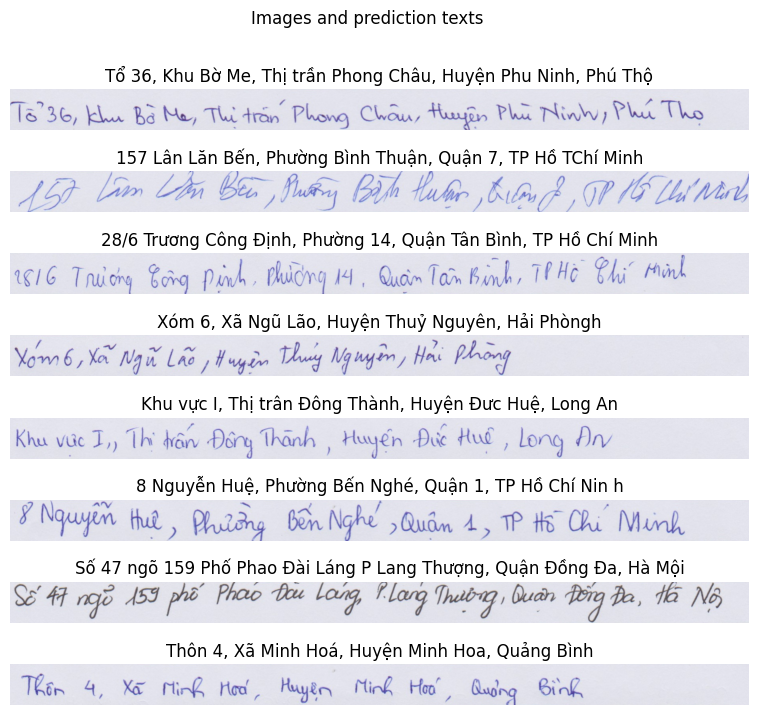

In [215]:
plot_images(
    images, prediction_texts,
    'Images and prediction texts', 1
)

# Finish

In [80]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
lr-AdamW,████████████████████████████████▂▂▂▂▂▂▂▁
train_loss_epoch,███▇▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,██▆▆▅▄▅▄▄▃▃▂▂▃▃▃▁▂▂▂▂▂▁▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇██
val_loss,███▆▅▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
epoch,131
lr-AdamW,0.0
train_loss_epoch,0.32276
train_loss_step,0.32567
trainer/global_step,24287


# Debug

In [82]:
for batch in train_dl:
    inputs, targets, texts = batch
    print(inputs.shape)
    print(type(targets))
    print((texts))
    print(targets[0].shape[0])
    break

torch.Size([8, 3, 103, 1853])
<class 'list'>
['548-550 Điện Biên Phủ, Phường Thanh Khê Đông, Quận Thanh Khê, Đà Nẵng', '2380 Đường Số 1, Phường 10, Quận Tân Bình, TP Hồ Chí Minh', '26 Võ Văn Kiệt, Phường Nguyễn Thái Bình, Quận 1, TP Hồ Chí Minh', '45 Đường Số 27 P.Tân Phong, Phường Tân Phong, Quận 7, TP Hồ Chí Minh', 'Phòng B411 nhà B, số 10 Tôn Thất Thuyết, Quận Cầu Giấy, Hà Nội', '33 Trần Phú, Thị trấn Chí Thạnh, Huyện Tuy An, Phú Yên', 'Xã Lộc Sơn, Xã Lộc Sơn, Huyện Hậu Lộc, Thanh Hoá', 'Số 58, phố Ngọc Hà, Phường Đội Cấn, Quận Ba Đình, Hà Nội']
69


In [50]:
def encode(targets):
    joined_targets = torch.cat(targets, dim=0)
    target_lengths = torch.tensor([target.size(0) for target in targets])
    return joined_targets, target_lengths

model = CRNN(cfg.dataset.vocab_size)
ctc_loss = nn.CTCLoss()
metrics = torchmetrics.MetricCollection([
    torchmetrics.text.CharErrorRate(),
    torchmetrics.text.WordErrorRate(),
])

In [51]:
token_lst = ['_'] + [c for c in characters]
print(len(token_lst))

141


In [52]:
from ctcdecode import CTCBeamDecoder

decoder = CTCBeamDecoder(
    token_lst,
    model_path=None,
    alpha=0,
    beta=0,
    cutoff_top_n=40,
    cutoff_prob=1.0,
    beam_width=3,
    num_processes=4,
    blank_id=0,
    log_probs_input=True
)
# beam_results, beam_scores, timesteps, out_lens = decoder.decode(output)

In [53]:
for batch in train_dl:
    inputs, targets = batch
    print(type(targets[0]))
    encoded_targets, target_lengths = encode(targets)
    print(encoded_targets.shape)
    print(target_lengths)
    logits = model(inputs)
    logit_lengths = torch.full(
    size=(logits.size(1),), 
    fill_value=logits.size(0), 
    dtype=torch.int32
    )
    print(f"logits shape: {logits.shape}")
    print(logit_lengths.shape)

    loss = ctc_loss(
        logits.log_softmax(2),
        encoded_targets,
        logit_lengths,
        target_lengths
    )
    print(loss)
    beam_results, beam_scores, timesteps, out_lens = decoder.decode(logits.log_softmax(2).permute(1, 0, 2))
    print(beam_results.shape)
    print(beam_scores.shape)
    print(timesteps.shape)
    print(out_lens.shape)
    break


<class 'torch.Tensor'>
torch.Size([412])
tensor([53, 60, 56, 54, 56, 33, 39, 61])
logits shape: torch.Size([231, 8, 141])
torch.Size([8])
tensor(19.4579, grad_fn=<MeanBackward0>)
torch.Size([8, 3, 231])
torch.Size([8, 3])
torch.Size([8, 3, 231])
torch.Size([8, 3])


In [55]:
beam_idx = beam_scores[0].argmax()
beam_output_arr = beam_results[0][beam_idx][:out_lens[0][beam_idx]]

In [56]:
bs_output = ''.join([idx2char[i.item()] for i in beam_output_arr])
bs_output

"ù17ấMKJổM#ồợVồư4ớợùTăMợMổT1'đJNăMăgẵJồổũấổvấổịổợ4Mă+MTợổJấợvợ6ổcổGMớổ+MG-+ợMJùãổ+zgc1MặcÊũ-ểMVổọG+ũăMJồzJổMJMổJ+"

In [57]:
def postprocess(beam_output):
    target_lst = []
    cur_c = '$'
    pre_c = '$'
    for c in beam_output:
        if c != '_' and c != pre_c:
            target_lst.append(c)
        pre_c = c

        
    return ''.join(target_lst)
postprocess(bs_output)

"ù17ấMKJổM#ồợVồư4ớợùTăMợMổT1'đJNăMăgẵJồổũấổvấổịổợ4Mă+MTợổJấợvợ6ổcổGMớổ+MG-+ợMJùãổ+zgc1MặcÊũ-ểMVổọG+ũăMJồzJổMJMổJ+"

In [58]:
# Chuỗi output từ CTC (không có khoảng trắng giữa các ký tự)
ctc_output_1 = "hh_e_ll_oo_"   # Sau xử lý: "hello"

ctc_output_2 = "the___cat_ran" # Sau xử lý: "the cat ran"

ctc_output_3 = "bo_ok__k"      # Sau xử lý: "book"

ctc_output_4 = "my__name_is___john"  # Sau xử lý: "my name is john"

ctc_output_5 = "hheelloo"  # Nếu xử lý sai: "hheelloo"
                           # Nếu có blank đúng: "h_e_ll_o" → "hello"
postprocess(ctc_output_3)

'bookk'